<h1> Image Deblurring Project </h1>

<strong> Setting up </strong>

In [1]:
%pip install pylops

Note: you may need to restart the kernel to use updated packages.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pywt
import pylops

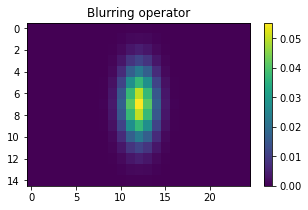

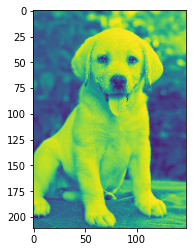

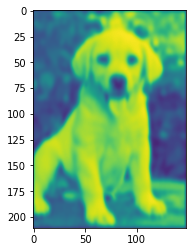

In [2]:
from matplotlib import image
sampling = 5
im = np.load("dog_rgb.npy")[::sampling, ::sampling, 2]
Nz, Nx = im.shape

# Blurring guassian operator
nh = [15, 25]
hz = np.exp(-0.1 * np.linspace(-(nh[0] // 2), nh[0] // 2, nh[0]) ** 2)
hx = np.exp(-0.3 * np.linspace(-(nh[1] // 2), nh[1] // 2, nh[1]) ** 2)
hz /= np.trapz(hz)  # normalize the integral to 1
hx /= np.trapz(hx)  # normalize the integral to 1
h = hz[:, np.newaxis] * hx[np.newaxis, :]

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
him = ax.imshow(h)
ax.set_title("Blurring operator")
fig.colorbar(him, ax=ax)
ax.axis("tight")
plt.show()
Cop = pylops.signalprocessing.Convolve2D(
    (Nz, Nx), h=h, offset=(nh[0] // 2, nh[1] // 2), dtype="float32"
)

imblur = Cop * im 
plt.imshow(im, cmap="viridis", vmin=0, vmax=255)
plt.savefig('dog.pdf')
plt.show()
plt.imshow(imblur, cmap="viridis", vmin=0, vmax=255)
plt.savefig('dogblur.pdf')
plt.show()

In [3]:
def grad(A,b,x):
    M=A.H
    S=M@A
    return S@x-M@b

def f(A,b,x,eps):
    return (1 / 2) * np.linalg.norm(A @ x - b, ord=2) ** 2 + eps * np.linalg.norm(x, ord=1)

In [4]:
def my_fista(A,b,opt_cost, eps=1e-1,niter=100,tol=1e-10,acceleration=False):
    
    if(acceleration==False):
        x = np.zeros(A.shape[1])
        xn = x.copy()
        S=A.H@A
        L=np.max(S.eigs(neigs=1,symmetric=True))
    
        alpha = 1/L
    
        opt_gap_cost = []
        k=1
        gap_cost=10
        while((k<=niter) and (opt_gap>tol)) :
            v=x-alpha*grad(A,b,x)
            for j in range(len(x)):
                xn[i] = np.sign(v[i]) * np.maximum(0, np.abs(v[i]) - alpha*eps)
            opt_gap=np.linalg.norm(x_new - x)
            gap_cost=np.abs(f(A,b,xn,eps)-opt_cost)
            opt_gap_cost.append(opt_gap)
            k+=1
            x=xn
  
    if(acceleration==True):
        x=np.zeros(A.shape[1])
        
        y = np.zeros(A.shape[1])
        yn = y.copy()
        lbda=0
        lbdan=(1+np.sqrt(1+4*lbda**2))/2
        gamma=(1-lbda)/lbdan
        
        L = np.max(S.eigs(neigs=1,symmetric=True))

        alpha = 1/L
    
        opt_gap_cost = []
        k=1
        gap_cost=10
        while((k<=niter) and (gap_cost>tol)) :
            v=x-alpha*grad(A,b,x)
            for j in range(len(y)):
                yn[i] = np.sign(v[i]) * np.maximum(0, np.abs(v[i]) - alpha*eps)
            x=gamma*y+(1-gamma)*yn
            lbda=lbdan
            lbdan=(1+sqrt(1+4*lbda**2))/2
            gamma=(1-lbda)/lbdan
            y=yn
            opt_gap=np.linalg.norm(x_new - x)
            gap_cost=np.abs(f(A,b,xn,eps)-opt_cost)
            opt_gap_cost.append(gap_cost)
            k+=1
            
    return x, opt_gap, opt_gap_cost
    
        
        

In [ ]:
Wop = pylops.signalprocessing.DWT2D((Nz, Nx), wavelet="haar", level=3)

#This is your A and b for your f1 cost!
A = Cop * Wop.H
b = imblur.ravel()

# Baseline from pylops
imdeblurfista0, n_eff_iter, cost_history = pylops.optimization.sparsity.fista(
    A, b, eps=1e-1, niter=1000
)

opt_cost = cost_history[-1] 

# ISTA
my_imdeblurfista, opt_gap, opt_gap_cost = my_fista(
    Cop * Wop.H, imblur.ravel(), opt_cost,eps=1e-1, niter=100, acceleration=False)

# FISTA
my_imdeblurfista1, opt_gap1, opt_gap_cost1 = my_fista(
    Cop * Wop.H, imblur.ravel(), opt_cost,eps=1e-1, niter=100, acceleration=True)


plt.loglog(opt_gap_cost,'C0', label='ISTA')
plt.loglog(opt_gap_cost1,'C1', label='FISTA')
plt.grid()
plt.loglog([3, 30],[1e6, 1e5], 'C0--', label='1/k')
plt.loglog([3, 30],[.5e5, .5e3], 'C1--', label='1/k2')

plt.legend()
plt.show()

imdeblurfista = my_imdeblurfista1.reshape((Cop * Wop.H).dims)
imdeblurfista = Wop.H * imdeblurfista

<strong> Image visualization </strong>

In [1]:
fig = plt.figure(figsize=(12, 6))
fig.suptitle("Deblurring", fontsize=14, fontweight="bold", y=0.95)
ax1 = plt.subplot2grid((2, 5), (0, 0))
ax2 = plt.subplot2grid((2, 5), (0, 1))
ax3 = plt.subplot2grid((2, 5), (0, 2))

ax1.imshow(im, cmap="viridis", vmin=0, vmax=250)
ax1.axis("tight")
ax1.set_title("Original")
ax2.imshow(imblur, cmap="viridis", vmin=0, vmax=250)
ax2.axis("tight")
ax2.set_title("Blurred")

ax3.imshow(imdeblurfista, cmap="viridis", vmin=0, vmax=250)
ax3.axis("tight")
ax3.set_title("FISTA deblurred")

plt.tight_layout()
plt.subplots_adjust(top=0.8)

NameError: name 'plt' is not defined